In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import copy


In [14]:
# find a slope of price line 
def indSlope(series,n):
    
    array_sl = [j*0 for j in range(n-1)]
    
    for j in range(n,len(series)+1):
        y = series[j-n:j]
        x = np.array(range(n))
        x_sc = (x - x.min())/(x.max() - x.min())
        y_sc = (y - y.min())/(y.max() - y.min())
        x_sc = sm.add_constant(x_sc)
        model = sm.OLS(y_sc,x_sc)
        results = model.fit()
        array_sl.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(array_sl))))
    return np.array(slope_angle)

In [15]:
# True Range and Average True Range indicator

def indATR(source_DF,n):
    df = source_DF.copy()
    df['H-L']=abs(df['high']-df['low'])
    df['H-PC']=abs(df['high']-df['close'].shift(1))
    df['L-PC']=abs(df['low']-df['close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df_temp = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df_temp

In [16]:
# generate data frame with all needed data

def PrepareDF(DF):
    ohlc = DF.iloc[:,[0,1,2,3,4,5]]
    ohlc.columns = ["date","open","high","low","close","volume"]
    ohlc=ohlc.set_index('date')
    df = indATR(ohlc,14).reset_index()
    df['slope'] = indSlope(df['close'],5)
    df['channel_max'] = df['high'].rolling(10).max()
    df['channel_min'] = df['low'].rolling(10).min()
    df['position_in_channel'] = (df['close']-df['channel_min']) / (df['channel_max']-df['channel_min'])
    df = df.set_index('date')
    df = df.reset_index()
    return(df)

In [17]:
# find local mimimum / local maximum

def isLCC(DF,i):
    df=DF.copy()
    LCC=0
    
    if df['close'][i]<=df['close'][i+1] and df['close'][i]<=df['close'][i-1] and df['close'][i+1]>df['close'][i-1]:
        #found the bottom
        LCC = i-1;
    return LCC

def isHCC(DF,i):
    df=DF.copy()
    HCC=0
    if df['close'][i]>=df['close'][i+1] and df['close'][i]>=df['close'][i-1] and df['close'][i+1]<df['close'][i-1]:
        #found the top
        HCC = i;
    return HCC

In [18]:
def getMaxMinChannel(DF, n):
    maxx=0
    minn=DF['low'].max()
    for i in range (1,n):
        if maxx<DF['high'][len(DF)-i]:
            maxx=DF['high'][len(DF)-i]
        if minn>DF['low'][len(DF)-i]:
            minn=DF['low'][len(DF)-i]
    return(maxx,minn)

In [19]:
apiKey='C1W4EKA40AF6PWTW' 

interval_var = '5min'
symbol='ETH'

path='https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol='+symbol+'&market=CNY&interval='+interval_var+'&apikey='+apiKey+'&datatype=csv&outputsize=full'
df = pd.read_csv(path)

In [20]:
# convert time order
df=df[::-1]

In [21]:
prepared_df=PrepareDF(df)

In [22]:
lend=len(prepared_df)

prepared_df['hcc']=[None]*lend
prepared_df['lcc']=[None]*lend

for i in range(4,lend-1):
    if isHCC(prepared_df,i)>0:
        prepared_df.at[i,'hcc']=prepared_df['close'][i]
    if isLCC(prepared_df,i)>0:
        prepared_df.at[i,'lcc']=prepared_df['close'][i]

In [24]:
position=0
eth_proffit_array=[[20,1],[40,1],[60,2],[80,2],[100,2],[150,1],[200,1],[200,0]]
deal=0
prepared_df['deal_o']=[None]*lend
prepared_df['deal_c']=[None]*lend
prepared_df['earn']=[None]*lend

for i in range(4,lend-1):
    prepared_df.at[i,'earn']=deal

    if position>0:
        # add profit/loss for long
        if(prepared_df['close'][i]<stop_price):
            # stop loss
            deal=deal+(prepared_df['close'][i]-open_price)*position
            prepared_df.at[i,'deal_c']=prepared_df['close'][i]
            position=0
        else:
            temp_arr=copy.copy(proffit_array)
            for j in range(0,len(temp_arr)-1):
                delta=temp_arr[j][0]
                contracts=temp_arr[j][1]
                if(prepared_df['close'][i]>(open_price+delta)):
                # take profit
                    prepared_df.at[i,'deal_c']=prepared_df['close'][i]
                    deal=deal+(prepared_df['close'][i]-open_price)*contracts
                    position=position-contracts
                    del proffit_array[0]
        
    elif position<0:
        # add profit/loss for short
        if(prepared_df['close'][i]>stop_price):
            # stop loss
            deal=deal+(open_price-prepared_df['close'][i])*position
            prepared_df.at[i,'deal_c']=prepared_df['close'][i]
            position=0
        else:
            temp_arr=copy.copy(proffit_array)
            for j in range(0,len(temp_arr)-1):
                delta=temp_arr[j][0]
                contracts=temp_arr[j][1]
                if((open_price-prepared_df['close'][i])>delta):
                # take profit
                    prepared_df.at[i,'deal_c']=prepared_df['close'][i]
                    deal=deal+(open_price-prepared_df['close'][i])*contracts
                    position=position+contracts
                    del proffit_array[0]

    else:
    # try to find enter point
        if prepared_df['lcc'][i-1]!=None:
           # found bottom - OPEN LONG
            if prepared_df['position_in_channel'][i-1]<0.5:
                # close to top of channel
                if prepared_df['slope'][i-1]<-20:
                    # found a good enter point
                    if position==0:
                        proffit_array=copy.copy(eth_proffit_array)
                        position=10
                        open_price=prepared_df['close'][i]
                        stop_price=prepared_df['close'][i]*0.99
                        prepared_df.at[i,'deal_o']=prepared_df['close'][i]
        if prepared_df['hcc'][i-1]!=None:
           # found top - OPEN SHORT
            if prepared_df['position_in_channel'][i-1]>0.5:
                # close to top of channel
                if prepared_df['slope'][i-1]>20:
                    # found a good enter point
                    if position==0:
                        proffit_array=copy.copy(eth_proffit_array)
                        position=-10
                        open_price=prepared_df['close'][i]
                        stop_price=prepared_df['close'][i]*1.003
                        prepared_df.at[i,'deal_o']=prepared_df['close'][i]


    
hours=round(lend*5/60,0)
print('Total erned in ',hours,' hours =',int(deal),'$')

Total erned in  83.0  hours = 271933 $


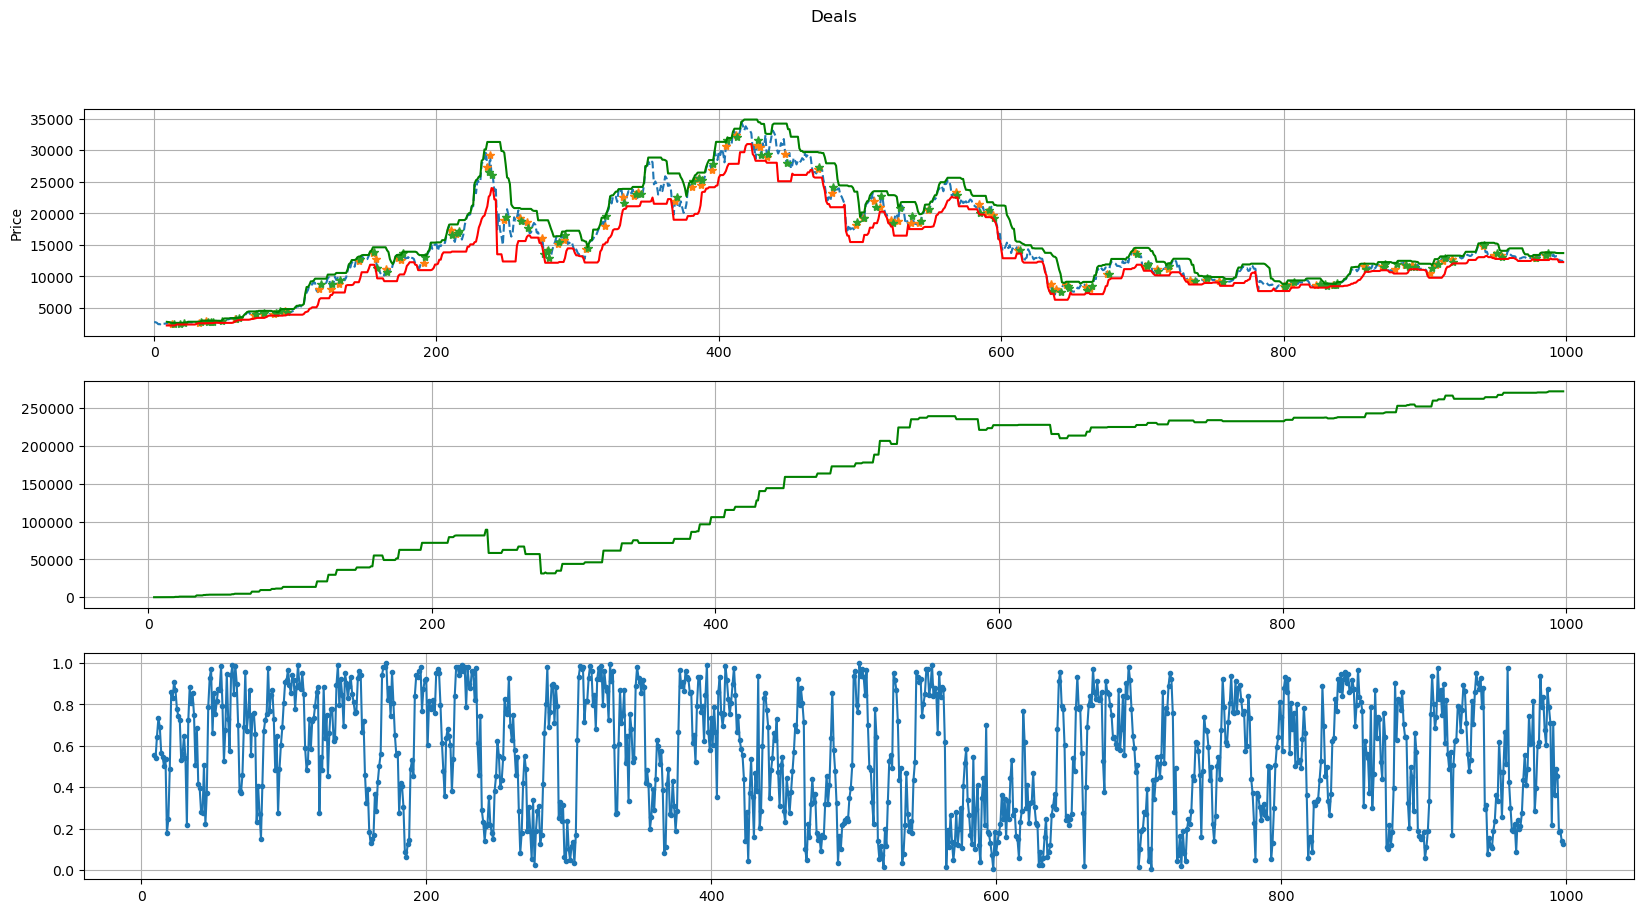

In [25]:
aa = prepared_df[0:999]
aa=aa.reset_index()

#labels = ['close',"deal_o","deal_c"]
labels = ['close',"deal_o","deal_c","channel_max","channel_min"]

labels_line = ['--',"*-","*-","g-","r-"]


j=0
x = pd.DataFrame()
y = pd.DataFrame()
for i in labels:
    x[j]=aa['index']
    y[j]=aa[i]
    j=j+1

fig, (ax1, ax2,ax3) = plt.subplots(3, 1)

fig.suptitle('Deals')
fig.set_size_inches(20, 10)

for j in range(0,len(labels)):
    ax1.plot(x[j], y[j], labels_line[j])


ax1.set_ylabel('Price')
ax1.grid(True)

ax2.plot(x[0], aa['earn'], 'g-') 
ax3.plot(x[0], aa['position_in_channel'], '.-') 

ax2.grid(True)
ax3.grid(True)

plt.show()